In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
import matplotlib.pyplot as plt

In [51]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

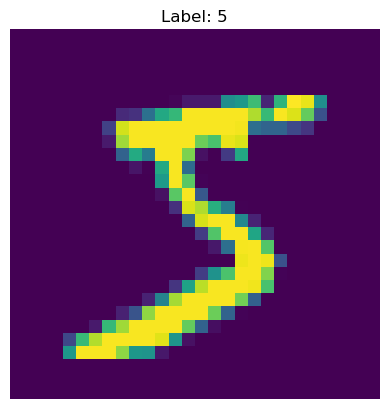

In [52]:
plt.imshow(x_train[0])
plt.title(f"Label: {y_train[0]}")
plt.axis("off")
plt.show()

In [53]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat)).batch(batch_size)

In [54]:
x_train.shape

(60000, 28, 28, 1)

# Teacher Model

In [55]:
def build_teacher():
    inputs = keras.Input(shape = (28, 28, 1))
    x = layers.Conv2D(128, 3, activation = "relu")(inputs)
    x = layers.Conv2D(128, 3, activation = "relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(256, 3, activation = "relu")(x)
    x = layers.Conv2D(256, 3, activation = "relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation = "relu")(x)
    outputs = layers.Dense(10)(x)
    return keras.Model(inputs, outputs, name = "teacher")

In [56]:
teacher = build_teacher()

In [57]:
teacher.compile(
    optimizer = "adamW",
    loss = keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [58]:
print("Training the Teacher Model...")

Training the Teacher Model...


In [59]:
teacher.fit(train_ds, epochs = 5, validation_data = test_ds)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 425ms/step - accuracy: 0.8511 - loss: 0.4482 - val_accuracy: 0.9725 - val_loss: 0.0909
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 429ms/step - accuracy: 0.9734 - loss: 0.0871 - val_accuracy: 0.9855 - val_loss: 0.0467
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 442ms/step - accuracy: 0.9830 - loss: 0.0556 - val_accuracy: 0.9829 - val_loss: 0.0535
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 434ms/step - accuracy: 0.9870 - loss: 0.0423 - val_accuracy: 0.9899 - val_loss: 0.0293
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 440ms/step - accuracy: 0.9893 - loss: 0.0344 - val_accuracy: 0.9908 - val_loss: 0.0265


In [62]:
teacher.trainable = False

In [63]:
def build_student():
    inputs = keras.Input(shape = (28, 28, 1))
    x = layers.Conv2D(32, 3, activation = "relu")(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation = "relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation = "relu")(x)
    outputs = layers.Dense(10)(x)
    return keras.Model(inputs, outputs, name = "student")

In [64]:
student = build_student()

In [65]:
class Distiller(keras.Model):
    def __init__(self, student, teacher, temperature = 5.0, alpha = 0.7):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss_fn = keras.losses.CategoricalCrossentropy(from_logits = True)
        self.kl_loss_fn = keras.losses.KLDivergence()
        self.student_acc = keras.metrics.CategoricalAccuracy()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        t = self.temperature
        with tf.GradientTape() as tape:
            teacher_logits = self.teacher(x, training = False)
            student_logits = self.student(x, training = True)

            ce_loss = self.ce_loss_fn(y, student_logits)

            p_t = tf.nn.softmax(teacher_logits / t, axis = 1)
            q_t = tf.nn.softmax(student_logits / t, axis = 1)
            kd_loss = self.kl_loss_fn(p_t, q_t)

            # loss = self.alpha * ce_loss + (1 - self.alpha) * (t**2) * kd_loss
            loss = (self.alpha * kd_loss) + (1 - self.alpha) * ce_loss     # loss form the Paper "Analysis and Tuning of Knowledge Distillation for Efficient Colloborative Learning"
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        self.student_acc.update_state(y, tf.nn.softmax(student_logits, axis = 1))
        return {"loss": loss, "student_acc": self.student_acc.result()}

    def test_step(self, data):
        x, y = data
        logits = self.student(x, training = False)
        ce_loss = self.ce_loss_fn(y, logits)
        self.student_acc.update_state(y, tf.nn.softmax(logits, axis = 1))
        return {"loss": ce_loss, "student_acc": self.student_acc.result()}

In [66]:
distiller = Distiller(student = student, teacher = teacher, temperature = 5.0, alpha = 0.7)

In [67]:
distiller.compile(optimizer = keras.optimizers.AdamW(1e-4))

In [68]:
print("Training Student with KD...")

Training Student with KD...


In [69]:
distiller.fit(train_ds, epochs = 15, validation_data = test_ds)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - loss: 1.4110 - student_acc: 0.1631 - val_loss: 2.0594 - val_student_acc: 0.2811
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 140ms/step - loss: 1.1779 - student_acc: 0.3286 - val_loss: 1.6300 - val_student_acc: 0.3545
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 155ms/step - loss: 1.0387 - student_acc: 0.4065 - val_loss: 1.4853 - val_student_acc: 0.4259
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - loss: 0.9894 - student_acc: 0.4554 - val_loss: 1.2855 - val_student_acc: 0.4876
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 178ms/step - loss: 0.9997 - student_acc: 0.5045 - val_loss: 1.2237 - val_student_acc: 0.5423
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 197ms/step - loss: 0.9715 - student_acc: 0.5582 - val_loss: 1.1379 - val_student_acc: 0.5994
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - loss: 0.8276 - student_acc: 0.6086 - val_loss: 0.9661 - val_student_acc: 0.6493
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 8

In [70]:
print("Final Evaluation Results...")

Final Evaluation Results...


In [71]:
student_logits = student.predict(x_test, batch_size = batch_size)
student_preds = tf.nn.softmax(student_logits, axis = 1)
acc = np.mean(np.argmax(student_preds,  axis = 1) == y_test)
print(f"Student Accuracy: {acc:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Student Accuracy: 0.7893


In [72]:
teacher.summary()

Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,424 (12.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,102,474 (4.21 MB)

 Optimizer params: 2,204,950 (8.41 MB)

In [73]:
student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,626 (92.29 KB)

 Trainable params: 23,626 (92.29 KB)

 Non-trainable params: 0 (0.00 B)